### Necessary Set-up

In [ ]:
import numpy as np
import networkx as nx
import pandas as pd
import tensorflow as tf

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Embedding
from tensorflow.python.ops.losses import losses


import time
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from tensorflow.python.client import device_lib

# from sklearn.manifold import TSNE


tsne_model = TSNE(learning_rate=100)

In [ ]:
tf.__version__
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5634096053948997665
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1518388938346130374
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
Num GPUs Available:  1


### The Embedder Model

#### Model Architecture, Losses and Accuracy

##### The Encoder Model

In [ ]:
def build_encoder(embedding_size):
  model = Sequential()

  # The first encoder layer
  model.add(Dense(embedding_size*4, activation='relu'))

  # The second encoder layer
  model.add(Dense(embedding_size*2, activation='relu'))

  # The output layer
  model.add(Dense(embedding_size, activation='relu'))

  return model


##### The Decoder Model

In [ ]:
def build_decoder(embedding_size, output_size):
  model = Sequential()

  # The first decoder layer
  model.add(Dense(embedding_size*2, activation='relu'))

  # The secod decoder layer
  model.add(Dense(embedding_size*4, activation='relu'))

  # The third decoder layer
  model.add(Dense(output_size, activation='sigmoid'))

  return model


##### Putting together the Ecnoder and Decoder into an AutoEncoder

In [ ]:
def build_ae(encoder, decoder, output_size):

  input_tensor = Input(shape=(output_size,))
  embeddings = encoder(input_tensor)
  reconstructions = decoder(embeddings)

  auto_encoder = Model(input_tensor, reconstructions)

  return auto_encoder

##### The Auto-encoder Loss and Acuraccy

In [ ]:
def recon_loss(x, x_hat):

  return tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, x_hat))

In [ ]:
def first_order_loss(X, Z):

    X = tf.cast(X, tf.float32)
    Z= tf.cast(Z, tf.float32)

    D = tf.linalg.diag(tf.reduce_sum(X,1))
    L = D - X ## L is laplation-matriX

    return 2*tf.linalg.trace(tf.matmul(tf.matmul(tf.transpose(Z),L),Z))

In [ ]:
def ae_adversarial_loss(X, Z, x, x_hat, d_z0, d_z1, first_order, alpha):

  # Recon loss
  reccon_loss = recon_loss(x, x_hat)
  f1_loss = first_order_loss(X, Z)

  if first_order =='with_f1':
      reccon_loss += alpha * f1_loss

  ### Loss 2 -> Same as the loss of the generator
  adversarial_loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(tf.ones_like(d_z0), d_z0)) + \
                     tf.reduce_sum(tf.keras.losses.binary_crossentropy(tf.zeros_like(d_z1), d_z1))

  return  reccon_loss  + 10 * adversarial_loss

In [ ]:
def ae_accuracy(x, x_hat):
  round_x_hat = tf.round(x_hat)
  return tf.reduce_mean(tf.cast(tf.equal(x, round_x_hat), tf.float32))

#### Pretraining the Embedder

In [ ]:
def pretrain_step_embd(X, x, encoder, decoder, auto_encoder, pre_optimizer, first_order, alpha):

  with tf.GradientTape() as pre_tape:
    z = encoder(x, training=True)
    x_hat = decoder(z, training=True)

    Z = encoder(X, training=True)

    pre_loss = recon_loss(x, x_hat)

    if first_order == 'with_f1':
        pre_loss += alpha * first_order_loss(X, Z)


  pre_gradients = pre_tape.gradient(pre_loss, auto_encoder.trainable_variables)
  pre_optimizer.apply_gradients(zip(pre_gradients, auto_encoder.trainable_variables))

  pre_acc = ae_accuracy(x, x_hat)

  return tf.reduce_mean(pre_loss), pre_acc

In [ ]:
def pretrain_embd(X, idxs, encoder, decoder, auto_encoder, pre_optimizer, first_order, alpha):
  np.random.shuffle(idxs)
  PRE_EPOCHS = 300
  Batch_size = 50

  for epoch in range(PRE_EPOCHS):

    epoch_losses = []
    epoch_acc = []

    for batch_idx in range(0, len(idxs), Batch_size):

      selected_idxs = idxs[batch_idx : batch_idx + Batch_size]
      adjacency_batch = X[selected_idxs, :]

      loss, accuracy= pretrain_step_embd(X, tf.cast(adjacency_batch, tf.float32), encoder, decoder, auto_encoder, pre_optimizer, first_order, alpha)

      epoch_losses.append(loss)
      epoch_acc.append(accuracy)

#     if epoch % 50 == 0:
#        print(f"Loss is {np.array(epoch_losses).mean()} and accuracy is {np.array(epoch_acc).mean()}")

### The Discriminator Model

#### Model Architecture

In [ ]:
def build_discriminator(embedding_size):
  model = Sequential()

  # The input layer
  model.add(Input(shape=(embedding_size,)))

  # The first hidden layer
  model.add(Dense(25, activation='relu'))
  model.add(Dropout(0.25))

  # The second layer
  model.add(Dense(15, activation='relu'))
  model.add(Dropout(0.20))

  # The third layer
  model.add(Dense(6, activation='relu'))
  model.add(Dropout(0.20))

  model.add(Dense(1, activation = 'sigmoid'))

  return model

In [ ]:
def disc_loss_function(d_z0, d_z1):

  loss_zero = tf.keras.losses.binary_crossentropy(tf.zeros_like(d_z0), d_z0)
  loss_one = tf.keras.losses.binary_crossentropy(tf.ones_like(d_z1), d_z1)

  return tf.cast(loss_zero, tf.float32) + tf.cast(loss_one, tf.float32)

#### Joint Training in a step

In [ ]:
def train_step(X, x0, x1, encoder, decoder, auto_encoder, discriminator, ae_optimizer, disc_optimizer, first_order, alpha):
  with tf.GradientTape() as ae_tape, tf.GradientTape() as disc_tape:

    z0 = encoder(x0, training=True)
    z1 = encoder(x1, training=True)

    Z = encoder(X, training=True)

    d_z0 = discriminator(z0, training=True)
    d_z1 = discriminator(z1, training=True)

    x0_hat = decoder(z0, training=True)
    x1_hat = decoder(z1, training = True)


    ae_loss = ae_adversarial_loss(X, Z, tf.concat([x0, x1], 0), tf.concat([x0_hat, x1_hat], 0), d_z0, d_z1, first_order, alpha)
    disc_loss = disc_loss_function(d_z0, d_z1)


  gradients_ae = ae_tape.gradient(ae_loss, auto_encoder.trainable_variables)
  gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  ae_optimizer.apply_gradients(zip(gradients_ae, auto_encoder.trainable_variables))
  disc_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

  ae_acc = ae_accuracy(tf.concat([x0, x1], 0), tf.concat([x0_hat, x1_hat], 0))

  return tf.reduce_mean(ae_loss), ae_acc, tf.reduce_mean(disc_loss)

#### Pretrain Step for Discriminator

In [ ]:
def pretrain_step_disc(x0, x1, encoder, discriminator, disc_pre_optimizer):

  z0 = encoder(x0)
  z1 = encoder(x1)

  with tf.GradientTape() as disc_tape_sep:

    d_z0= discriminator(z0, training=True)
    d_z1 = discriminator(z1, training=True)

    disc_loss = disc_loss_function(d_z0, d_z1)


  gradients_disc = disc_tape_sep.gradient(disc_loss, discriminator.trainable_variables)
  disc_pre_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

  return tf.reduce_mean(disc_loss)

#### Pretraining the discriminator

In [ ]:
def pretrain_disc(X, idxs_zeros, idxs_ones, encoder, discriminator, disc_pre_optimizer):

  EPOCHS = 40

  np.random.shuffle(idxs_zeros)
  np.random.shuffle(idxs_ones)
  Batch_size = 50

  for epoch in range(EPOCHS):
    for batch_idx in range(0, len(idxs_ones), Batch_size):

      selected_zeros = idxs_zeros[batch_idx : batch_idx + Batch_size]
      selected_ones = idxs_ones[batch_idx : batch_idx + Batch_size]

      x0 = X[selected_zeros]
      x1 = X[selected_ones]

      pretrain_step_disc(x0, x1, encoder, discriminator, disc_pre_optimizer)


#### The Train Loop

In [ ]:
def adversarial_train(X, idxs_zeros, idxs_ones, encoder, decoder, auto_encoder, discriminator, ae_optimizer, disc_optimizer, first_order, alpha):
    EPOCHS = 500

    np.random.shuffle(idxs_zeros)
    np.random.shuffle(idxs_ones)

    Batch_size = 50

    for epoch in range(EPOCHS):
        for batch_idx in range(0, len(idxs_ones), Batch_size):

          selected_zeros = idxs_zeros[batch_idx : batch_idx + Batch_size]
          selected_ones = idxs_ones[batch_idx : batch_idx + Batch_size]

          x0 = X[selected_zeros]
          x1 = X[selected_ones]

          ### Joint Training
          train_step(X, tf.cast(x0, tf.float32), tf.cast(x1, tf.float32), encoder, decoder,
                                                     auto_encoder, discriminator, ae_optimizer, disc_optimizer, first_order, alpha)

### Piciking the Seeds Using Embedding

In [ ]:
def get_seeds_KMeans(N_CLUS, embedding, nodes, labels, nodes_zero, nodes_one, strategy, n_seeds):
    '''
    stratgey can be random, nearest, fair, re-cluster, fair_re-cluster
    '''

    # model = KMeans(n_clusters=N_CLUS)
    model = KMeans(n_clusters=N_CLUS, n_init = 10)
    model.fit(embedding)

    cluster_number = model.labels_
    centers = model.cluster_centers_

    seed_ids = [[] for i in range(N_CLUS)]

    for i in range(N_CLUS):

        if strategy == 'nearest':
          sorted_distance = np.array(sorted([[np.sqrt(np.sum(np.power(centers[i] - embedding[j], 2))), j] for j in range(len(embedding)) if i == cluster_number[j]]))
          seed_ids[i].extend(list(sorted_distance[:n_seeds, 1]))


        elif strategy == 're-cluster':
          temp = []
          sorted_distance = np.array(sorted([[np.sqrt(np.sum(np.power(centers[i] - embedding[j], 2))), j] for j in range(len(embedding)) if i == cluster_number[j]]))
          temp.extend(list(sorted_distance[:n_seeds, 1]))

          portion_zero = 0
          portion_one = 0

          for num in temp:
            if num in nodes_zero:
              portion_zero += 1
            elif num in nodes_one:
              portion_one += 1

          zero_in_clus = embedding[np.logical_and(cluster_number == i, labels == 0)]
          zero_inds = nodes[np.logical_and(cluster_number == i, labels == 0)]

          one_in_clus = embedding[np.logical_and(cluster_number == i, labels == 1)]
          one_inds = nodes[np.logical_and(cluster_number == i, labels == 1)]

          added_to_zero = 0
          if len(zero_in_clus) != 0:
              model_on_zero = KMeans(n_clusters=1, n_init = 2)
              model_on_zero.fit(zero_in_clus)
              center_zero = model_on_zero.cluster_centers_

              sorted_distance_zero = np.array(sorted([[np.sqrt(np.sum(np.power(center_zero - zero_in_clus[j], 2))), j] for j in range(len(zero_in_clus))]))
              seed_ids[i].extend([zero_inds[int(i)] for i in sorted_distance_zero[:portion_zero, 1]])

              added_to_zero = len(seed_ids[i])
              assert added_to_zero == portion_zero

          added_to_one = 0
          if len(one_in_clus) != 0:
              model_on_one = KMeans(n_clusters=1, n_init = 2)
              model_on_one.fit(one_in_clus)
              center_one = model_on_one.cluster_centers_

              sorted_distance_one = np.array(sorted([[np.sqrt(np.sum(np.power(center_one - one_in_clus[j], 2))), j] for j in range(len(one_in_clus))]))
              seed_ids[i].extend([one_inds[int(i)] for i in sorted_distance_one[:portion_one, 1]])

              added_to_one = len(seed_ids[i]) - added_to_zero
              assert added_to_one == portion_one

          assert n_seeds == added_to_zero + added_to_one
          assert len(seed_ids[i]) == n_seeds

    return np.reshape(seed_ids, newshape=(-1, ))

In [ ]:
def get_seeds_Spectral_Clustering(N_CLUS, embeddings, nodes, labels, nodes_zero, nodes_one, strategy, n_seeds):
    model = SpectralClustering(n_clusters=N_CLUS, affinity='nearest_neighbors', random_state=0)
    cluster_labels = model.fit_predict(embeddings)

    seed_ids = [[] for _ in range(N_CLUS)]

    for i in range(N_CLUS):
        cluster_nodes = [node for node, label in zip(nodes, cluster_labels) if label == i]
        seed_ids[i].extend(cluster_nodes[:n_seeds])

    return np.array(seed_ids).flatten()

### The IC algorithm

In [ ]:
def IC(G, seeds, imp_prob, recover_prob = 0, remove = 0):

    impressed = []
    removed = []
    front = list(seeds[:])

    while front:
        impressed.extend(front)
        impressed = np.array(impressed)

        if recover_prob != 0:

            random_draws = np.random.uniform(size=len(impressed))

            if remove:
                removed.extend(impressed[random_draws < recover_prob])
                removed = list(set(removed))

            impressed = impressed[random_draws >= recover_prob]

        impressed = list(impressed)
        new_front = []

        for node in front:

            neighbours = list(G.neighbors(node))

            for neigh in neighbours:

                expr_prob = np.random.uniform(size=1)[0]
                if expr_prob < imp_prob and not (neigh in impressed) and not (neigh in new_front) and not (neigh in removed):
                    new_front.append(neigh)

        front = new_front[:]

    impressed = np.reshape(np.array(impressed), newshape=(-1,))

    return impressed

#### Repeated IC

In [ ]:
def repeated_IC(G, nodes_zero, nodes_one, seeds, seeds_type, n_expr, imp_prob, recover_prob = 0, remove = 0):
  zeros_count = []
  ones_count = []
  total_count = []

  for i in range(n_expr):
    impressed = IC(G, seeds, imp_prob, recover_prob = recover_prob, remove = remove)
    total_count.append(len(impressed))

    count_zeros = 0
    count_ones = 0

    for imp in impressed:
      if imp in nodes_zero:
        count_zeros += 1
      elif imp in nodes_one:
        count_ones += 1

    zeros_count.append(count_zeros)
    ones_count.append(count_ones)

  total_imp = np.round(np.mean(total_count), 2)
  total_fraction = np.round(total_imp / len(G.nodes()), 3)

  fraction_zero = np.round(np.mean(zeros_count) / len(nodes_zero), 3)
  fraction_one = np.round(np.mean(ones_count) / len(nodes_one), 3)

  return total_imp, total_fraction, fraction_zero, fraction_one


### Loading the real graph

In [ ]:
def get_graph_real():
  # graph_df = pd.read_csv('/content/sample_data/edges.txt', sep="\t", header=None)
  graph_df = pd.read_csv('/content/edges.txt', sep="\t", header=None)
  graph_df.columns = ['s', 't']

  # attr_df = pd.read_csv('/content/sample_data/attr.txt', sep="\t", header=None)
  attr_df = pd.read_csv('/content/attr.txt', sep="\t", header=None)
  attr_df.columns = ['id', 'College', 'Age', 'Major']

  edges = []

  for index, row in graph_df.iterrows():
    edge_cur = (row.s, row.t)

    edges.append(edge_cur)

  input_G = nx.from_edgelist(edges)

  extra_nodes = []
  for index, row in attr_df.iterrows():
    if row.Age > 20:
      extra_nodes.append(row.id)

  unfrozen_G = nx.Graph(input_G)

  for node in input_G.nodes():
    if node in extra_nodes:
      unfrozen_G.remove_node(node)

  X = nx.to_numpy_array(unfrozen_G)
  G = nx.from_numpy_array(X)

  return G, X, unfrozen_G

In [ ]:
def get_nodes_labels_real(input_G):
  # data = pd.read_csv('/content/sample_data/attr.txt', sep="\t", header=None)
  data = pd.read_csv('/content/attr.txt', sep="\t", header=None)
  data.columns = ['id', 'College', 'Age', 'Major']

  dict_labels = {}

  for index, row in data.iterrows():
    if row.Age <+ 20:
      dict_labels[row.id] = 0
    # elif row.Age == 20:
    #   dict_labels[row.id] = 1
    else:
      dict_labels[row.id] = 1

  labels = []
  for node in list(input_G.nodes()):
    labels.append(dict_labels[node])

  # Remember that whenever you want do logical operation on a sequence, that sequence should be numpy array
  labels = np.array(labels)

  nodes = np.arange(len(input_G.nodes()))

  nodes_zero = nodes[labels == 0]
  nodes_one = nodes[labels == 1]

  return nodes_zero, nodes_one, labels

In [ ]:
def get_idxs(n, nodes_zero, nodes_one):

  diff_size = np.abs(len(nodes_one) - len(nodes_zero))

  idxs_zeros = nodes_zero[:]
  idxs_ones = nodes_one[:]
  rep_policy = False

  if len(nodes_zero) < len(nodes_one):
    if diff_size > len(nodes_zero):
      rep_policy = True
    zero_draws = np.random.choice(nodes_zero,size=diff_size, replace=rep_policy)
    idxs_zeros = np.concatenate((idxs_zeros, zero_draws))

  elif len(nodes_zero) > len(nodes_one):
    if diff_size > len(nodes_one):
      rep_policy = True
    one_draws = np.random.choice(nodes_one,size=diff_size, replace=rep_policy)
    idxs_ones = np.concatenate((idxs_ones, one_draws))

  assert len(idxs_zeros) == len(idxs_ones)

  return np.arange(n), idxs_zeros, idxs_ones


In [ ]:
def print_edges(G, nodes_zero, nodes_one):
  zero_edges = 0
  one_edges = 0
  accross_edges = 0

  for (v1, v2) in G.edges():
    if v1 in nodes_zero and v2 in nodes_zero:
      zero_edges += 1
    elif v1 in nodes_one and v2 in nodes_one:
      one_edges += 1
    elif v1 in nodes_one and v2 in nodes_zero:
      accross_edges += 1
    elif v1 in nodes_zero and v2 in nodes_one:
      accross_edges += 1

  print(f" edges in zero community: {zero_edges}")
  print(f" edges in one community: {one_edges}")
  print(f" edges across communities: {accross_edges}")


### Running the experiments

In [ ]:
embedding_size = 30

# Can get `with_f1` or `without_f1`
first_order_imp = 'no_f1'
alpha = 0.05

# 1. Creating the Graph and Getting the Adj Matrix
G, X, input_G = get_graph_real()
n = len(G.nodes())

# 2. Getting seperate lists for seperate communities and the label for each community
nodes_zero, nodes_one, labels = get_nodes_labels_real(input_G)

print_edges(G, nodes_zero, nodes_one)

# 3. Getting the idxs suitable for training.
idxs, idxs_zeros, idxs_ones = get_idxs(n, nodes_zero, nodes_one)

# 4. Creating the Embedder
encoder = build_encoder(embedding_size)
decoder = build_decoder(embedding_size, n)
auto_encoder = build_ae(encoder, decoder, n)

# 5. Creating the Discriminator
discriminator = build_discriminator(embedding_size)

# 6. Pretraining the Embedder and the Discriminator
pre_optimizer_embd = tf.keras.optimizers.Adam()
pre_optimizer_disc = tf.keras.optimizers.Adam()

pretrain_embd(X, idxs, encoder, decoder, auto_encoder, pre_optimizer_embd, first_order_imp, alpha)
pretrain_disc(X, idxs_zeros, idxs_ones, encoder, discriminator, pre_optimizer_disc)
# print('6')

# # 6-1. Get the pretrain-embeddings
pre_embds = encoder(X)
print('pre-training done.')

 edges in zero community: 513
 edges in one community: 7441
 edges across communities: 1706


pre-training done.


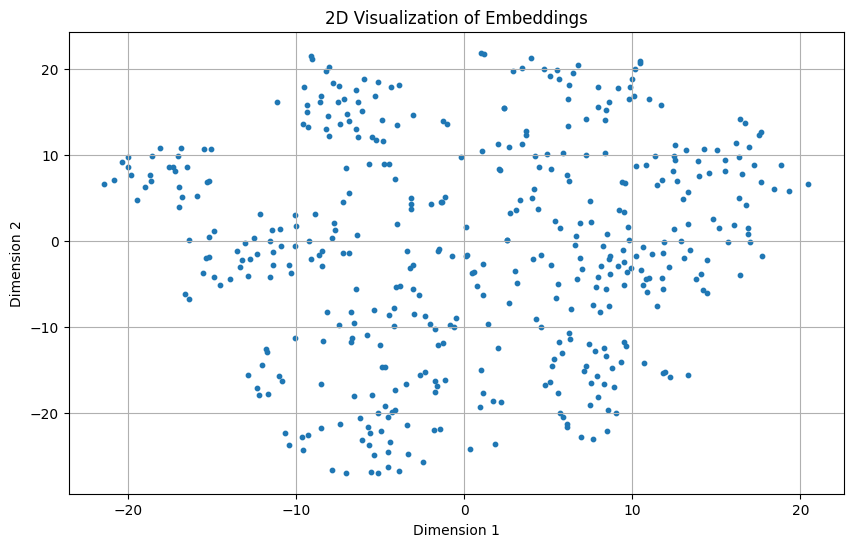

In [ ]:
# Reduce the dimensionality of the embeddings to 2D using t-SNE
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(pre_embds)

# Plot the 2D embeddings
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=10)  # Adjust s for marker size
plt.title('2D Visualization of Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

In [ ]:
# 7. Adversarial Training
ae_optimizer = tf.keras.optimizers.Adam()
disc_optimizer = tf.keras.optimizers.Adam()

adversarial_train(X, idxs_zeros, idxs_ones, encoder, decoder, auto_encoder, discriminator, ae_optimizer, disc_optimizer, first_order_imp, alpha)

#7-1. Getting the fair-embeddings
fair_embds = encoder(X)
print(fair_embds)

print('adversarial training done.')

tf.Tensor(
[[ 6.535372   3.462458  30.119017  ...  6.6949267 37.4795    15.433625 ]
 [ 5.756213   1.4351586 36.040943  ... 12.0271    48.103046  20.214975 ]
 [ 0.6298661  0.        28.75548   ...  1.7623596 39.740776  16.637297 ]
 ...
 [ 0.         0.        16.759424  ...  2.80366   14.712961   5.8458834]
 [ 0.         0.        16.759424  ...  2.80366   14.712961   5.8458834]
 [ 0.         0.        27.041777  ... 14.021838  29.10542    3.1448612]], shape=(441, 30), dtype=float32)
adversarial training done.


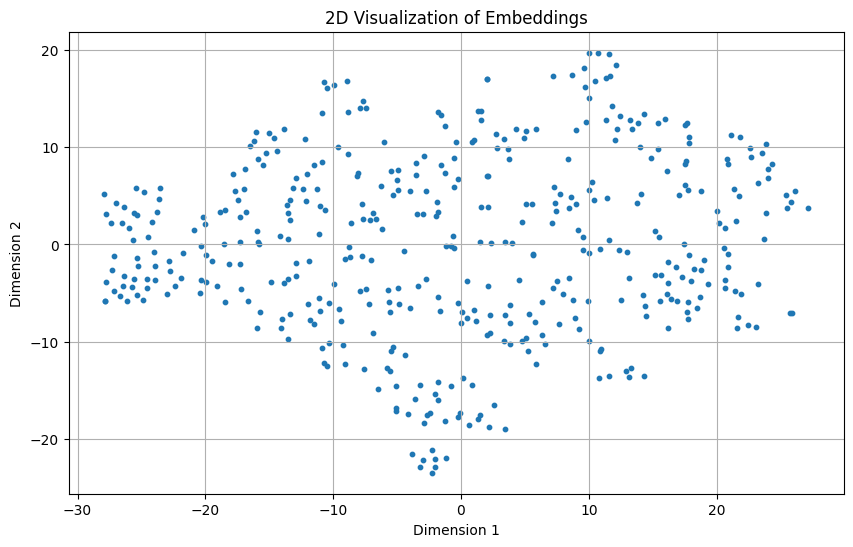

In [ ]:
# Reduce the dimensionality of the embeddings to 2D using t-SNE
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(fair_embds)

# Plot the 2D embeddings
plt.figure(figsize=(10, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=10)  # Adjust s for marker size
plt.title('2D Visualization of Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

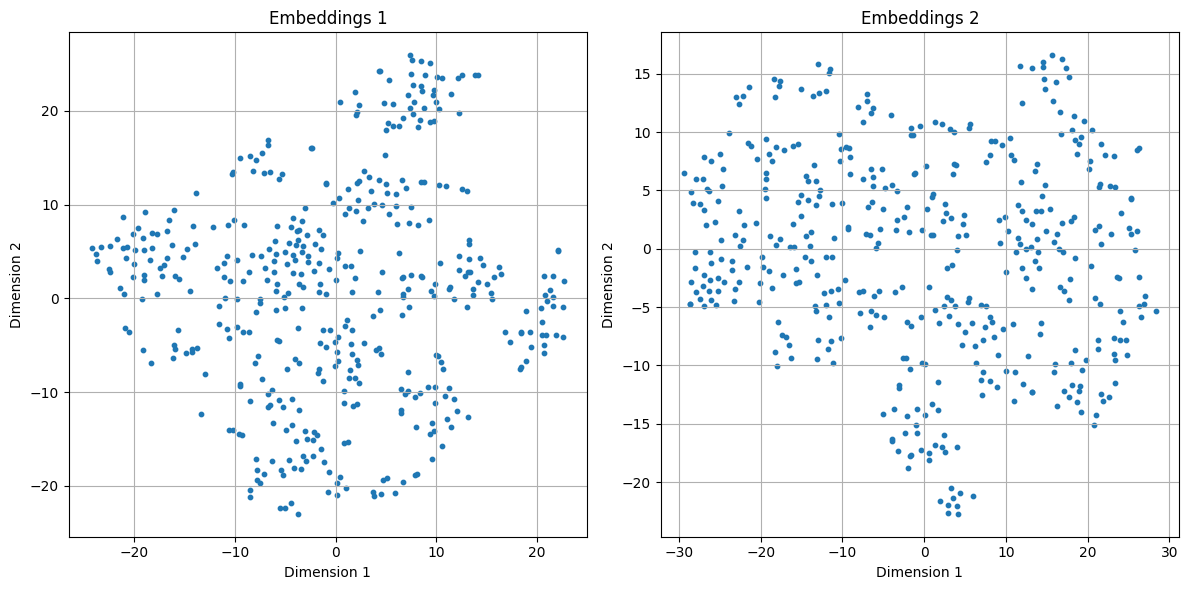

In [ ]:
# Reduce the dimensionality of the embeddings to 2D using t-SNE
tsne = TSNE(n_components=2)

# Fit and transform embeddings for the first plot
embeddings_2d_1 = tsne.fit_transform(pre_embds)

# Fit and transform embeddings for the second plot
embeddings_2d_2 = tsne.fit_transform(fair_embds)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first 2D embeddings
axs[0].scatter(embeddings_2d_1[:, 0], embeddings_2d_1[:, 1], s=10)
axs[0].set_title('Embeddings 1')
axs[0].set_xlabel('Dimension 1')
axs[0].set_ylabel('Dimension 2')
axs[0].grid(True)

# Plot the second 2D embeddings
axs[1].scatter(embeddings_2d_2[:, 0], embeddings_2d_2[:, 1], s=10)
axs[1].set_title('Embeddings 2')
axs[1].set_xlabel('Dimension 1')
axs[1].set_ylabel('Dimension 2')
axs[1].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

#### Experiments settings

In [ ]:
# N_CLUSs = [4]
# n_seedss = [1, 2, 3, 4, 5, 6, 7, 8, 10]

N_CLUSs = [5]
n_seedss = [2]
# n_seedss = [8]

# Methods for getting the seeds can be nearest or re-cluster
strategy = 're-cluster'

In [ ]:
# @title K-Means Clustering
import matplotlib.pyplot as plt

rows = '['
first = True


for N_CLUS in N_CLUSs:
  for n_seeds in n_seedss:
    if first:
        first = False
    else:
        rows += ',\n'
    #8. Getting the seeds for the embeddings and baselines
    t1 = time.time()
    fair_seeds = get_seeds_KMeans(N_CLUS, fair_embds, idxs, labels, nodes_zero, nodes_one, strategy, n_seeds)
    t2 = time.time()
    print("Fair seeds: ", fair_seeds)
    fair_inf_spread = IC(G, fair_seeds, 0.2, 0, 0)
    print("Length of spread is: ", len(fair_inf_spread))
    # print("Fair Influenced nodes are: ", fair_inf_spread)
    print("Time for Fair seeds finding using KMeans:", t2-t1)
    print("\n\n")

    t3=time.time()
    pre_seeds = get_seeds_KMeans(N_CLUS, pre_embds, idxs, labels, nodes_zero, nodes_one, strategy, n_seeds)
    t4=time.time()
    print("Pre Seeds: ", pre_seeds)
    pre_inf_spread = IC(G, pre_seeds, 0.2, 0, 0)
    print("Length of spread is: ", len(pre_inf_spread))
    # print("Pre Influenced nodes are: ", pre_inf_spread)
    print("Time for Pre seeds finding using KMeans:", t3-time.time())



    #9. Getting the final results
    total_fair, fair_frac, zero_fair, one_fair = repeated_IC(G, nodes_zero, nodes_one, fair_seeds, 'fair', 2000, 0.01)
    total_pre, pre_frac, zero_pre, one_pre = repeated_IC(G, nodes_zero, nodes_one, pre_seeds, 'pre', 2000, 0.01)

    #10. Building the current row and adding it to the rows.
    row =[ embedding_size ,  N_CLUS,  n_seeds, total_fair, fair_frac, zero_fair, one_fair,  total_pre ,  pre_frac ,  zero_pre ,  one_pre, '\'' + strategy + '\'']
    # print(row)

    rows += '[' + ', '.join(map(str, row)) + ']'

rows += ']'


print(rows)




Fair seeds:  [186 375  15  68  40  25 372 165 427  58]
Length of spread is:  430
Time for Fair seeds finding using KMeans: 1.7368340492248535



Pre Seeds:  [223 291 427  85 195 156  59 317 122 313]
Length of spread is:  432
Time for Pre seeds finding using KMeans: -1.8518435955047607
[[30, 5, 2, 21.88, 0.05, 0.012, 0.06, 18.27, 0.041, 0.021, 0.047, 're-cluster']]


In [ ]:
# @title Spectral Clustering
import matplotlib.pyplot as plt

rows = '['
first = True


for N_CLUS in N_CLUSs:
  for n_seeds in n_seedss:
    if first:
        first = False
    else:
        rows += ',\n'
    #8. Getting the seeds for the embeddings and baselines

    t1 = time.time()
    fair_seeds = get_seeds_Spectral_Clustering(N_CLUS, fair_embds, idxs, labels, nodes_zero, nodes_one, strategy, n_seeds)
    t2 = time.time()
    pre_seeds = get_seeds_Spectral_Clustering(N_CLUS, pre_embds, idxs, labels, nodes_zero, nodes_one, strategy, n_seeds)
    t3 = time.time()


    print("Fair seeds: ", fair_seeds)
    fair_inf_spread = IC(G, fair_seeds, 0.2, 0, 0)
    print("Length of spread is: ", len(fair_inf_spread))
    # print("Fair Influenced nodes are: ", fair_inf_spread)
    print("Time for Fair seeds using Spectral Clus is: ", t2-t1)
    print("\n\n")
    print("Pre Seeds: ", pre_seeds)
    pre_inf_spread = IC(G, pre_seeds, 0.2, 0, 0)
    print("Length of spread is: ", len(pre_inf_spread))
    # print("Pre Influenced nodes are: ", pre_inf_spread)
    print("Time for Pre seeds using Spectral Clus is: ", t3-t2)

    #9. Getting the final results
    total_fair, fair_frac, zero_fair, one_fair = repeated_IC(G, nodes_zero, nodes_one, fair_seeds, 'fair', 2000, 0.01)
    total_pre, pre_frac, zero_pre, one_pre = repeated_IC(G, nodes_zero, nodes_one, pre_seeds, 'pre', 2000, 0.01)

    #10. Building the current row and adding it to the rows.
    row =[ embedding_size ,  N_CLUS,  n_seeds, total_fair, fair_frac, zero_fair, one_fair,  total_pre ,  pre_frac ,  zero_pre ,  one_pre, '\'' + strategy + '\'']
    # print(row)

    rows += '[' + ', '.join(map(str, row)) + ']'

rows += ']'


print(rows)




Fair seeds:  [247 232 234  54 195 331 231 250 367  39]
Length of spread is:  429
Time for Fair seeds using Spectral Clus is:  0.16069841384887695



Pre Seeds:  [234  54 275 318 195 331 380 293 231 250]
Length of spread is:  425
Time for Pre seeds using Spectral Clus is:  0.19192004203796387
[[30, 5, 2, 19.1, 0.043, 0.055, 0.04, 17.33, 0.039, 0.064, 0.032, 're-cluster']]


Fair seeds:  [247 232 234  54 195 331 231 250 367  39]
Length of spread is:  429
Time for Fair seeds using Spectral Clus is:  0.1703801155090332



Pre Seeds:  [234  54 275 318 195 331 380 293 231 250]
Length of spread is:  426
Time for Pre seeds using Spectral Clus is:  0.17429852485656738
[30, 5, 2, 18.84, 0.043, 0.055, 0.039, 16.96, 0.038, 0.063, 0.031, "'re-cluster'"]


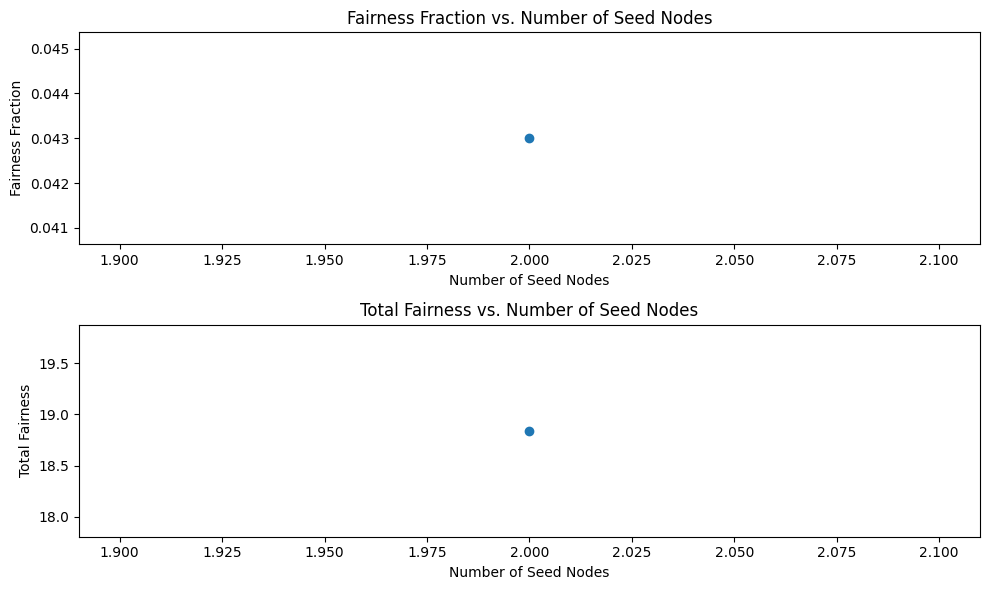

In [ ]:
# NEED TO CHANGE


import matplotlib.pyplot as plt

# Modify your code to collect data for plotting
fair_frac_values = []
total_fair_values = []
n_seeds_values = []

# Initialize 'first' variable
first = True

# Loop over your experiments and collect the relevant data
for N_CLUS in N_CLUSs:
    for n_seeds in n_seedss:
        #8. Getting the seeds for the embeddings and baselines

        t1 = time.time()
        fair_seeds = get_seeds_Spectral_Clustering(N_CLUS, fair_embds, idxs, labels, nodes_zero, nodes_one, strategy, n_seeds)
        t2 = time.time()
        pre_seeds = get_seeds_Spectral_Clustering(N_CLUS, pre_embds, idxs, labels, nodes_zero, nodes_one, strategy, n_seeds)
        t3 = time.time()


        print("Fair seeds: ", fair_seeds)
        fair_inf_spread = IC(G, fair_seeds, 0.2, 0, 0)
        print("Length of spread is: ", len(fair_inf_spread))
        # print("Fair Influenced nodes are: ", fair_inf_spread)
        print("Time for Fair seeds using Spectral Clus is: ", t2-t1)
        print("\n\n")
        print("Pre Seeds: ", pre_seeds)
        pre_inf_spread = IC(G, pre_seeds, 0.2, 0, 0)
        print("Length of spread is: ", len(pre_inf_spread))
        # print("Pre Influenced nodes are: ", pre_inf_spread)
        print("Time for Pre seeds using Spectral Clus is: ", t3-t2)

        #9. Getting the final results
        total_fair, fair_frac, zero_fair, one_fair = repeated_IC(G, nodes_zero, nodes_one, fair_seeds, 'fair', 2000, 0.01)
        total_pre, pre_frac, zero_pre, one_pre = repeated_IC(G, nodes_zero, nodes_one, pre_seeds, 'pre', 2000, 0.01)

        #10. Building the current row and adding it to the rows.
        row =[ embedding_size ,  N_CLUS,  n_seeds, total_fair, fair_frac, zero_fair, one_fair,  total_pre ,  pre_frac ,  zero_pre ,  one_pre, '\'' + strategy + '\'']
        print(row)

        # After obtaining results for each experiment, collect the data
        fair_frac_values.append(fair_frac)  # Assuming fair_frac is calculated in your experiments
        total_fair_values.append(total_fair)  # Assuming total_fair is calculated in your experiments
        n_seeds_values.append(n_seeds)

# Plot the graphs
plt.figure(figsize=(10, 6))

# Plot Fairness Fraction vs. Number of Seed Nodes
plt.subplot(2, 1, 1)
plt.plot(n_seeds_values, fair_frac_values, marker='o', linestyle='-')
plt.xlabel('Number of Seed Nodes')
plt.ylabel('Fairness Fraction')
plt.title('Fairness Fraction vs. Number of Seed Nodes')

# Plot Total Fairness vs. Number of Seed Nodes
plt.subplot(2, 1, 2)
plt.plot(n_seeds_values, total_fair_values, marker='o', linestyle='-')
plt.xlabel('Number of Seed Nodes')
plt.ylabel('Total Fairness')
plt.title('Total Fairness vs. Number of Seed Nodes')

plt.tight_layout()
plt.show()


In [ ]:
# NEED TO CHANGE


# import matplotlib.pyplot as plt

# # Assuming you have collected the data for Spectral Clustering in a list called spectral_data
# spectral_data = [n_seeds, fair_frac]  # Data collected for Spectral Clustering

# # Extracting the parameters for plotting
# fair_frac_spectral = [row[4] for row in spectral_data]  # Fairness Fraction for Spectral Clustering
# n_seeds_spectral = [row[2] for row in spectral_data]  # Number of Seeds for Spectral Clustering

# # Plotting the graph
# plt.figure(figsize=(8, 6))

# # Plotting Fairness Fraction vs Number of Seeds
# plt.scatter(n_seeds_spectral, fair_frac_spectral, label='Spectral Clustering', color='blue', marker='o')
# plt.xlabel('Number of Seeds')
# plt.ylabel('Fairness Fraction')
# plt.title('Fairness Fraction vs Number of Seeds for Spectral Clustering')
# plt.legend()

# plt.show()


In [ ]:
import pickle

with open('embeddings_6.pickle', 'wb') as f:
    pickle.dump([G, embedding_size, fair_embds, pre_embds, idxs, labels, nodes_zero, nodes_one], f)

print('Saved')

Saved


In [ ]:
# @title Affinity Propagation
from sklearn.cluster import AffinityPropagation

# Define a function to perform Affinity Propagation clustering
def perform_affinity_propagation(embeddings):
    # Create an Affinity Propagation instance
    affinity_propagation = AffinityPropagation(damping=0.9, preference=-50)

    # Fit the embeddings to the clustering algorithm
    affinity_propagation.fit(embeddings)

    # Get the cluster centers
    cluster_centers_indices = affinity_propagation.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)

    # Get the labels assigned to each data point
    labels = affinity_propagation.labels_

    return n_clusters_, labels

# Call the function to perform Affinity Propagation clustering on the fair embeddings
n_clusters, labels = perform_affinity_propagation(fair_embds)

# Print the number of clusters and the labels assigned to each data point
print("Number of clusters:", n_clusters)
print("Cluster Labels:", labels)

# Define a function to find the densest node within each cluster
def find_densest_node_within_cluster(G, labels):
    densest_nodes = []

    # Iterate over each cluster
    for cluster_label in range(max(labels) + 1):
        cluster_nodes = [node for node, label in zip(G.nodes(), labels) if label == cluster_label]

        max_degree = -1
        densest_node = None

        # Find the node with the highest degree within the cluster
        for node in cluster_nodes:
            node_degree = G.degree[node]
            if node_degree > max_degree:
                max_degree = node_degree
                densest_node = node

        densest_nodes.append(densest_node)

    return densest_nodes

# Call the function to find the densest node within each cluster
densest_nodes = find_densest_node_within_cluster(G, labels)

# Print the densest nodes
print("Densest Nodes within Clusters:", densest_nodes)

# Now, you can use these densest nodes as seed nodes for your influence maximization algorithm.


Number of clusters: 439
Cluster Labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 23

In [ ]:
import networkx as nx
import heapq
import random

def celf_influence_maximization_with_embeddings(embeddings, k):
    """
    CELF algorithm for influence maximization using node embeddings.

    Args:
        embeddings: Embeddings of nodes generated by the autoencoder.
        k: the number of nodes to select.

    Returns:
        A list of k nodes that maximizes the spread of influence.
    """

    S = [] # Selected nodes
    pq = [] # Priority queue of candidate nodes

    # Compute the marginal gain of each node
    for node in range(len(embeddings)):
        mg = get_marginal_gain_with_embeddings(embeddings, S, node)
        heapq.heappush(pq, (-mg, node))

    # Select the top k nodes with highest marginal gain
    while len(S) < k:
        _, node = heapq.heappop(pq)

        # while node in S:
        #     _, node = heapq.heappop(pq)

        S.append(node)
        # Edited down 5 lines
        # updated_pq = []
        # for _, candidate_node in pq:
        #     mg = get_marginal_gain_with_embeddings(embeddings, S, candidate_node)
        #     heapq.heappush(updated_pq, (-mg, candidate_node))
        # pq = updated_pq

        # Update the priority queue with the new marginal gains
        for neighbor in range(len(embeddings)):
            if neighbor not in S:
                mg = get_marginal_gain_with_embeddings(embeddings, S, neighbor)
                heapq.heappush(pq, (-mg, neighbor))

    return S

def get_marginal_gain_with_embeddings(embeddings, S, node):
    """
    Compute the marginal gain of a node given a set of seed nodes S using embeddings.

    Args:
        embeddings: Embeddings of nodes generated by the autoencoder.
        S: a list of seed nodes.
        node: the node to evaluate.

    Returns:
        The marginal gain of the node.
    """

    if node in S:
        return 0

    H = nx.Graph() # Create a graph for computing influence spread
    H.add_node(node) # Add the node to the graph
    for n in S:
        H.add_node(n) # Add seed nodes to the graph
        H.add_edge(node, n, weight=similarity(embeddings[node], embeddings[n])) # Add edges with similarity as weight

    # Compute the influence spread of the node
    activated_nodes = set([node])
    while True:
        activated_nodes_prev = activated_nodes.copy()
        for n in activated_nodes_prev:
            for m in H.neighbors(n):
                if m not in activated_nodes:
                    if random.random() < H[n][m]['weight']:
                        activated_nodes.add(m)
        if activated_nodes == activated_nodes_prev:
            break
    influence = len(activated_nodes)

    # Compute the marginal gain
    return influence - len(S)

def similarity(embedding1, embedding2):
    """
    Compute similarity between two node embeddings.

    Args:
        embedding1: embedding vector of node 1.
        embedding2: embedding vector of node 2.

    Returns:
        Similarity score between the two embeddings.
    """
    # Example similarity measure: cosine similarity
    dot_product = sum(a * b for a, b in zip(embedding1, embedding2))
    magnitude1 = sum(a ** 2 for a in embedding1) ** 0.5
    magnitude2 = sum(b ** 2 for b in embedding2) ** 0.5
    similarity_score = dot_product / (magnitude1 * magnitude2)
    return similarity_score

# Assuming you have generated the fair and pre embeddings from the existing code
fair_embeddings = fair_embds.numpy()
pre_embeddings = pre_embds.numpy()

# Set the number of nodes to select
k = 10

# Run CELF algorithm with fair embeddings
t1 = time.time()
fair_seed_nodes = celf_influence_maximization_with_embeddings(fair_embeddings, k)
t2 = time.time()
print("Fair Seed Nodes:", fair_seed_nodes)
fair_influenced_list = IC(G, fair_seed_nodes, 0.2, 0, 0)
print("Influence Spreadis: ", len(fair_influenced_list))
# print("Influence after fair seed embeddings:", influenced_list) #Edited
print("Time taken: ",t2-t1)
print("\n\n")
# Run CELF algorithm with pre embeddings
t3 = time.time()
pre_seed_nodes = celf_influence_maximization_with_embeddings(pre_embeddings, k)
t4 = time.time()
print("Pre Seed Nodes:", pre_seed_nodes)
pre_influenced_list = IC(G, pre_seed_nodes, 0.2, 0, 0)
print("Influence Spreadis: ", len(pre_influenced_list))
# print("Influence after fair seed embeddings:", influenced_list) #Edited
print("Time taken: ", t4-t3)

Fair Seed Nodes: [0, 1, 1, 2, 2, 2, 3, 3, 3, 4]
Influence Spreadis:  432
Time taken:  3.4232633113861084



Pre Seed Nodes: [0, 1, 1, 2, 2, 2, 3, 3, 3, 4]
Influence Spreadis:  437
Time taken:  3.4196579456329346


In [ ]:
import networkx as nx
import heapq
import random
from sklearn.cluster import SpectralClustering


def celf_influence_maximization_with_embeddings(embeddings, k):
    """
    CELF algorithm for influence maximization using node embeddings.

    Args:
        embeddings: Embeddings of nodes generated by the autoencoder.
        k: the number of nodes to select.

    Returns:
        A list of k nodes that maximizes the spread of influence.
    """

    S = [] # Selected nodes
    pq = [] # Priority queue of candidate nodes

    # Compute the marginal gain of each node
    cluster_model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=0)  # Assuming 2 clusters for demonstration
    cluster_labels = cluster_model.fit_predict(embeddings)

    for node in range(len(embeddings)):
        mg = get_marginal_gain_with_embeddings(embeddings, S, node, cluster_labels)
        heapq.heappush(pq, (-mg, node))

    # Select the top k nodes with highest marginal gain
    while len(S) < k:
        _, node = heapq.heappop(pq)
        S.append(node)
        # Update the priority queue with the new marginal gains
        for neighbor in range(len(embeddings)):
            if neighbor not in S:
                mg = get_marginal_gain_with_embeddings(embeddings, S, neighbor, cluster_labels)
                heapq.heappush(pq, (-mg, neighbor))

    return S


def get_marginal_gain_with_embeddings(embeddings, S, node, cluster_labels):
    """
    Compute the marginal gain of a node given a set of seed nodes S using embeddings.

    Args:
        embeddings: Embeddings of nodes generated by the autoencoder.
        S: a list of seed nodes.
        node: the node to evaluate.
        cluster_labels: Labels obtained from Spectral Clustering.

    Returns:
        The marginal gain of the node.
    """

    if node in S:
        return 0

    H = nx.Graph() # Create a graph for computing influence spread
    H.add_node(node) # Add the node to the graph
    for n in S:
        H.add_node(n) # Add seed nodes to the graph
        cluster_similarity = 1 if cluster_labels[node] == cluster_labels[n] else 0  # Check if nodes belong to the same cluster
        H.add_edge(node, n, weight=cluster_similarity) # Add edges with cluster similarity as weight

    # Compute the influence spread of the node
    activated_nodes = set([node])
    while True:
        activated_nodes_prev = activated_nodes.copy()
        for n in activated_nodes_prev:
            for m in H.neighbors(n):
                if m not in activated_nodes:
                    if random.random() < H[n][m]['weight']:
                        activated_nodes.add(m)
        if activated_nodes == activated_nodes_prev:
            break
    influence = len(activated_nodes)

    # Compute the marginal gain
    return influence - len(S)


def similarity(embedding1, embedding2):
    """
    Compute similarity between two node embeddings.

    Args:
        embedding1: embedding vector of node 1.
        embedding2: embedding vector of node 2.

    Returns:
        Similarity score between the two embeddings.
    """
    # Example similarity measure: cosine similarity
    dot_product = sum(a * b for a, b in zip(embedding1, embedding2))
    magnitude1 = sum(a ** 2 for a in embedding1) ** 0.5
    magnitude2 = sum(b ** 2 for b in embedding2) ** 0.5
    similarity_score = dot_product / (magnitude1 * magnitude2)
    return similarity_score

# Assuming you have generated the fair and pre embeddings from the existing code
fair_embeddings = fair_embds.numpy()
pre_embeddings = pre_embds.numpy()

# Assuming you have defined or imported the necessary variables and functions

# Set the number of nodes to select
k = 10

# Run CELF algorithm with fair embeddings
t1 = time.time()
fair_seed_nodes = celf_influence_maximization_with_embeddings(fair_embeddings, k)
t2 = time.time()
print("Fair Seed Nodes:", fair_seed_nodes)
fair_influenced_list = IC(G, fair_seed_nodes, 0.2, 0, 0)
print("Influence Spreadis: ", len(fair_influenced_list))
# print("Influence after fair seed embeddings:", influenced_list) #Edited
print("Time taken: ", t2-t1)
print("\n\n")
# Run CELF algorithm with pre embeddings
t3 = time.time()
pre_seed_nodes = celf_influence_maximization_with_embeddings(pre_embeddings, k)
t4 = time.time()
print("Pre Seed Nodes:", pre_seed_nodes)
pre_influenced_list = IC(G, pre_seed_nodes, 0.2, 0, 0)
print("Influence Spreadis: ", len(pre_influenced_list))
# print("Influence after fair seed embeddings:", influenced_list) #Edited
print("Time taken: ", t4-t3)

Fair Seed Nodes: [0, 1, 1, 2, 2, 2, 3, 3, 3, 4]
Influence Spreadis:  433
Time taken:  0.46750855445861816



Pre Seed Nodes: [0, 1, 1, 2, 2, 2, 3, 3, 3, 4]
Influence Spreadis:  432
Time taken:  0.7912683486938477


In [ ]:
import networkx as nx
from sklearn.cluster import SpectralClustering
from queue import PriorityQueue
import random

def celfpp_influence_maximization_with_embeddings(embeddings, k):
    """
    CELF++ algorithm for influence maximization using node embeddings.

    Args:
        embeddings: Embeddings of nodes generated by the autoencoder.
        k: the number of nodes to select.

    Returns:
        A list of k nodes that maximizes the spread of influence.
    """

    S = [] # Selected nodes
    pq = PriorityQueue() # Priority queue of candidate nodes

    # Spectral Clustering
    cluster_model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=0)  # Assuming 2 clusters for demonstration
    cluster_labels = cluster_model.fit_predict(embeddings)

    # Compute the marginal gain of each node
    for node in range(len(embeddings)):
        mg = get_marginal_gain_with_embeddings(embeddings, S, node, cluster_labels)
        pq.put((-mg, node))

    # Select the top k nodes with highest marginal gain
    while len(S) < k:
        while True:
            _, node = pq.get()
            if node not in S:
                S.append(node)
                break
        # Update the priority queue with the new marginal gains
        for neighbor in range(len(embeddings)):
            if neighbor not in S:
                mg = get_marginal_gain_with_embeddings(embeddings, S, neighbor, cluster_labels)
                if mg > 0:
                    old_mg = -pq.queue[-1][0] if pq.qsize() == k else 0
                    if mg > old_mg:
                        pq.put((-mg, neighbor))
                        if pq.qsize() > k:
                            pq.get()

    return S

def get_marginal_gain_with_embeddings(embeddings, S, node, cluster_labels):
    """
    Compute the marginal gain of a node given a set of seed nodes S using embeddings.

    Args:
        embeddings: Embeddings of nodes generated by the autoencoder.
        S: a list of seed nodes.
        node: the node to evaluate.
        cluster_labels: Labels obtained from Spectral Clustering.

    Returns:
        The marginal gain of the node.
    """

    if node in S:
        return 0

    H = nx.Graph() # Create a graph for computing influence spread
    H.add_node(node) # Add the node to the graph
    for n in S:
        H.add_node(n) # Add seed nodes to the graph
        cluster_similarity = 1 if cluster_labels[node] == cluster_labels[n] else 0  # Check if nodes belong to the same cluster
        H.add_edge(node, n, weight=cluster_similarity) # Add edges with cluster similarity as weight

    # Compute the influence spread of the node
    activated_nodes = set([node])
    while True:
        activated_nodes_prev = activated_nodes.copy()
        for n in activated_nodes_prev:
            for m in H.neighbors(n):
                if m not in activated_nodes:
                    if random.random() < H[n][m]['weight']:
                        activated_nodes.add(m)
        if activated_nodes == activated_nodes_prev:
            break
    influence = len(activated_nodes)

    # Compute the marginal gain
    return influence - len(S)

# Assuming you have generated the fair and pre embeddings from the existing code
fair_embeddings = fair_embds.numpy()
pre_embeddings = pre_embds.numpy()

# Set the number of nodes to select
k = 10

# Run CELF++ algorithm with fair embeddings
t1 = time.time()
fair_seed_nodes = celfpp_influence_maximization_with_embeddings(fair_embeddings, k)
t2 = time.time()
print("Fair Seed Nodes:", fair_seed_nodes)
fair_influenced_list = IC(G, fair_seed_nodes, 0.2, 0, 0)
print("Influence Spreadis: ", len(fair_influenced_list))
# print("Influence after fair seed embeddings:", influenced_list) #Edited
print("Time taken: ", t2-t1)
print("\n\n")

# Run CELF++ algorithm with pre embeddings
t3 = time.time()
pre_seed_nodes = celfpp_influence_maximization_with_embeddings(pre_embeddings, k)
t4 = time.time()
print("Pre Seed Nodes:", pre_seed_nodes)
pre_influenced_list = IC(G, pre_seed_nodes, 0.2, 0, 0)
print("Influence Spreadis: ", len(pre_influenced_list))
# print("Influence after fair seed embeddings:", influenced_list) #Edited
print("Time taken: ", t4-t3)

Fair Seed Nodes: [0, 183, 252, 294, 322, 336, 348, 357, 365, 370]
Influence Spreadis:  428
Time taken:  0.5417964458465576



Pre Seed Nodes: [0, 205, 287, 327, 349, 365, 375, 383, 389, 394]
Influence Spreadis:  432
Time taken:  0.24958157539367676


In [ ]:
import networkx as nx
import heapq
import random
from sklearn.cluster import SpectralClustering

def similarity(embedding1, embedding2):
  dot_product = sum(a * b for a, b in zip(embedding1, embedding2))
  magnitude1 = sum(a ** 2 for a in embedding1) ** 0.5
  magnitude2 = sum(b ** 2 for b in embedding2) ** 0.5
  return dot_product / (magnitude1 * magnitude2)

def celfie_influence_maximization_with_embeddings(embeddings, k, alpha=0.1):
  S = []
  pq = []

  cluster_model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=0)
  cluster_labels = cluster_model.fit_predict(embeddings)

  print("Cluster labels:", cluster_labels)

  for node in range(len(embeddings)):
      mg, ie = get_marginal_gain_and_influence_estimate_with_embeddings(embeddings, S, node, cluster_labels, alpha)
      heapq.heappush(pq, (-mg, node, ie))

  while len(S) < k:
      _, node, ie = heapq.heappop(pq)
      S.append(node)
      for neighbor in range(len(embeddings)):
          if neighbor not in S:
              mg, ie = get_marginal_gain_and_influence_estimate_with_embeddings(embeddings, S, neighbor, cluster_labels, alpha)
              heapq.heappush(pq, (-mg, neighbor, ie))

  # print("Fair Seed Nodes:", S)
  return S


def get_marginal_gain_and_influence_estimate_with_embeddings(embeddings, S, node, cluster_labels, alpha):
  if node in S:
      return 0, 0

  H = nx.Graph()
  H.add_node(node)
  for n in S:
      H.add_node(n)
      similarity1 = similarity(embeddings[node], embeddings[n]) if cluster_labels[node] == cluster_labels[n] else 0
      H.add_edge(node, n, weight=similarity1)

  activated_nodes = set([node])
  while True:
      activated_nodes_prev = activated_nodes.copy()
      for n in activated_nodes_prev:
          for m in H.neighbors(n):
              if m not in activated_nodes and random.random() < H[n][m]['weight']:
                  activated_nodes.add(m)
      if activated_nodes == activated_nodes_prev:
          break
  initial_influence = len(activated_nodes)

  H.nodes[node]['activated'] = True
  activated_nodes.add(node)
  while True:
      activated_nodes_prev = activated_nodes.copy()
      for n in activated_nodes_prev:
          for m in H.neighbors(n):
              if m not in activated_nodes and random.random() < H[n][m]['weight']:
                  activated_nodes.add(m)
      if activated_nodes == activated_nodes_prev:
          break
  influence = len(activated_nodes)

  ie = (influence - initial_influence) / alpha + initial_influence
  mg = ie - len(S)
  return mg, ie





# Assuming you have generated the fair and pre embeddings from the existing code
fair_embeddings = fair_embds.numpy()
pre_embeddings = pre_embds.numpy()

# Set the number of nodes to select
k = 10

# Run CELFIE algorithm with fair embeddings
t1 = time.time()
fair_seed_nodes = celfie_influence_maximization_with_embeddings(fair_embeddings, k)
t2 = time.time()
print("Fair Seed Nodes:", fair_seed_nodes)
fair_influenced_list = IC(G, fair_seed_nodes, 0.2, 0, 0)
print("Influence Spreadis: ", len(fair_influenced_list))
# print("Influence after fair seed embeddings:", influenced_list) #Edited
print("Time taken: ", t2-t1)
print("\n\n")

# Run CELFIE algorithm with pre embeddings
t3 = time.time()
pre_seed_nodes = celfie_influence_maximization_with_embeddings(pre_embeddings, k)
t4 = time.time()
print("Pre Seed Nodes:", pre_seed_nodes)
pre_influenced_list = IC(G, pre_seed_nodes, 0.2, 0, 0)
print("Influence Spreadis: ", len(pre_influenced_list))
# print("Influence after fair seed embeddings:", influenced_list) #Edited
print("Time taken: ", t4-t3)

Cluster labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0
 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0
 1 0 1 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0
 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 1 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1]
Fair Seed Nodes: [0, 9, 63, 276, 6, 16, 402, 154, 3, 10]
Influence Spreadis:  430
Time ta

In [ ]:
# # @title CELF with Graph (Not Embeddings)
# def celf_with_graph(g,k,p=0.1,mc=1000):
#     """
#     Input:  graph object, number of seed nodes
#     Output: optimal seed set, resulting spread, time for each iteration
#     """

#     # --------------------
#     # Find the first node with greedy algorithm
#     # --------------------

#     # Calculate the first iteration sorted list
#     start_time = time.time()
#     marg_gain = [IC(g,[node],p,mc) for node in range(g.vcount())]

#     # Create the sorted list of nodes and their marginal gain
#     Q = sorted(zip(range(g.vcount()),marg_gain), key=lambda x: x[1],reverse=True)

#     # Select the first node and remove from candidate list
#     S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
#     Q, LOOKUPS, timelapse = Q[1:], [g.vcount()], [time.time()-start_time]

#     # --------------------
#     # Find the next k-1 nodes using the list-sorting procedure
#     # --------------------

#     for _ in range(k-1):

#         check, node_lookup = False, 0

#         while not check:

#             # Count the number of times the spread is computed
#             node_lookup += 1

#             # Recalculate spread of top node
#             current = Q[0][0]

#             # Evaluate the spread function and store the marginal gain in the list
#             Q[0] = (current,IC(g,S+[current],p,mc) - spread)

#             # Re-sort the list
#             Q = sorted(Q, key = lambda x: x[1], reverse = True)

#             # Check if previous top node stayed on top after the sort
#             check = (Q[0][0] == current)

#         # Select the next node
#         spread += Q[0][1]
#         S.append(Q[0][0])
#         SPREAD.append(spread)
#         LOOKUPS.append(node_lookup)
#         timelapse.append(time.time() - start_time)

#         # Remove the selected node from the list
#         Q = Q[1:]

#     return(S,SPREAD,timelapse,LOOKUPS)

In [ ]:
import networkx as nx
import numpy as np
import time

def celf_with_graph(g, k, p=0.1, mc=100):
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """

    # --------------------
    # Find the first node with greedy algorithm
    # --------------------

    # Calculate the first iteration sorted list
    start_time = time.time()
    marg_gain = [IC(g, [node], p, mc) for node in range(len(g))]

    # Create the sorted list of nodes and their marginal gain
    Q = sorted(zip(range(len(g)), marg_gain), key=lambda x: x[1], reverse=True)

    # Select the first node and remove from candidate list
    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS, timelapse = Q[1:], [len(g)], [time.time() - start_time]

    # --------------------
    # Find the next k-1 nodes using the list-sorting procedure
    # --------------------

    for _ in range(k - 1):

        check, node_lookup = False, 0

        while not check:

            # Count the number of times the spread is computed
            node_lookup += 1

            # Recalculate spread of top node
            current = Q[0][0]

            # Evaluate the spread function and store the marginal gain in the list
            Q[0] = (current, IC(g, S + [current], p, mc) - spread)

            # Re-sort the list
            Q = sorted(Q, key=lambda x: x[1], reverse=True)

            # Check if previous top node stayed on top after the sort
            check = (Q[0][0] == current)

        # Select the next node
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        timelapse.append(time.time() - start_time)

        # Remove the selected node from the list
        Q = Q[1:]

    return (S, SPREAD, timelapse, LOOKUPS)

def IC(G, S, p, mc):
    """
    Input:  graph object, set of seed nodes, propagation probability
    Output: average number of nodes influenced by the seed nodes
    """
    spread = []
    for i in range(mc):
        new_active, A = S[:], S[:]
        while new_active:
            new_ones = []
            for node in new_active:
                np.random.seed(i)
                success = np.random.uniform(0, 1, len(G[node])) < p
                new_ones += list(np.extract(success, list(G[node])))

            new_active = list(set(new_ones) - set(A))
            A += new_active
        spread.append(len(A))
    return (float(sum(spread)) / mc)

# Example usage:
# Generate a NetworkX graph from a NumPy array
adjacency_matrix = np.random.randint(2, size=(10, 10))  # Example adjacency matrix
g = nx.from_numpy_array(adjacency_matrix)

# Set parameters
k = 5  # Number of seed nodes
p = 0.1  # Propagation probability
mc = 1000  # Monte Carlo simulations

# Run the CELF algorithm
result = celf_with_graph(g, k, p, mc)
print("Optimal Seed Set:", result[0])
print("Resulting Spread:", result[1][-1])
print("Time for Each Iteration:", result[2])
print("Number of Lookups for Each Iteration:", result[3])


Optimal Seed Set: [0, 5, 1, 3, 7]
Resulting Spread: 6.6
Time for Each Iteration: [0.5677065849304199, 1.5748050212860107, 2.19502854347229, 2.3721790313720703, 2.995861530303955]
Number of Lookups for Each Iteration: [10, 10, 7, 1, 5]


In [ ]:
# Run algorithms
t = time.time()
celf_output   = celf_with_graph(G,10,p = 0.1,mc = 1)
t1 = time.time()

# Print resulting seed sets
print("celf output:   " + str(celf_output[0]), "time : ", t1-t)
# influenced_list = IC(G, celf_output, 0.2, 0,0)
# print("Influence Spreadis: ", len(influenced_list))

dni_celf = IC(G,celf_output[0],p=0.5,mc=100)
print("DNI celf of erdos ",dni_celf)

celf output:   [11, 319, 428, 426, 365, 359, 334, 317, 310, 279] time :  8.456663608551025
DNI celf of erdos  434.64


In [ ]:
# # @title CELF++ with Graph (Not Embeddings)
# import numpy as np
# import heapq

# def celf_plus_plus(g, k, p=0.1, mc=100):
#     """
#     Input:  graph object, number of seed nodes
#     Output: optimal seed set, resulting spread, time for each iteration
#     """

#     # Initialize lists to store results
#     S, spread, timelapse, start_time = [], [0], [], time.time()

#     # Initialize priority queue Q
#     Q = []

#     # Initialize variables to keep track of last seed and current best
#     last_seed = None
#     cur_best = None

#     # Step 2: Initialize nodes with their marginal gains
#     for u in range(g.vcount()):
#         mg1 = IC(g, [u], p, mc)
#         mg2 = IC(g, [u, cur_best], p, mc) if cur_best is not None else mg1
#         node_data = (mg1, mg2, u, 0)
#         heapq.heappush(Q, node_data)

#     # Step 4: Update cur_best based on mg1 of the first node in Q
#     _, _, cur_best, _ = Q[0]

#     # Main loop
#     while len(S) < k:
#         # Step 6: Get the top (root) element in Q
#         mg1, mg2, u, flag = heapq.heappop(Q)

#         # Step 7: Check if node was flagged in the previous iteration
#         if flag == len(S):
#             # Step 8: Add u to the seed set S
#             S.append(u)
#             # Step 9: Remove u from Q
#             continue

#         # Step 10: Check if u.prev_best is equal to the last seed
#         if u == last_seed:
#             mg1 = mg2  # Step 11

#         # Step 12: Update mg1, mg2 for u
#         mg1 = IC(g, S + [u], p, mc) - spread[-1]
#         mg2 = IC(g, S + [u, cur_best], p, mc) - spread[-1]

#         # Step 13: Update u.prev_best and u.mg2
#         u_prev_best = cur_best
#         u_mg2 = mg2

#         # Step 14: Update cur_best
#         if mg1 > 0:
#             cur_best = u
#         else:
#             cur_best = u_prev_best

#         # Step 15: Reinsert u into Q and heapify
#         u_flag = len(S)
#         node_data = (mg1, u_mg2, u, u_flag)
#         heapq.heappush(Q, node_data)

#         # Update results
#         spread.append(spread[-1] + mg1)
#         timelapse.append(time.time() - start_time)

#         # Update last seed
#         last_seed = u

#     return S, spread[1:], timelapse



# # Example usage
# #G = Graph.Erdos_Renyi(n=100, m=300, directed=True)




In [ ]:
import numpy as np
import heapq
import time

def celf_plus_plus_with_Graph(g, k, p=0.1, mc=100):
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """

    # Initialize lists to store results
    S, spread, timelapse, start_time = [], [0], [], time.time()

    # Initialize priority queue Q
    Q = []

    # Initialize variables to keep track of last seed and current best
    last_seed = None
    cur_best = None

    # Convert the NetworkX graph to a NumPy adjacency matrix
    A = nx.to_numpy_array(g)

    # Step 2: Initialize nodes with their marginal gains
    for u in range(len(A)):
        mg1 = IC(A, [u], p, mc)
        mg2 = IC(A, [u, cur_best], p, mc) if cur_best is not None else mg1
        node_data = (mg1, mg2, u, 0)
        heapq.heappush(Q, node_data)

    # Step 4: Update cur_best based on mg1 of the first node in Q
    _, _, cur_best, _ = Q[0]

    # Main loop
    while len(S) < k:
        # Step 6: Get the top (root) element in Q
        mg1, mg2, u, flag = heapq.heappop(Q)

        # Step 7: Check if node was flagged in the previous iteration
        if flag == len(S):
            # Step 8: Add u to the seed set S
            S.append(u)
            # Step 9: Remove u from Q
            continue

        # Step 10: Check if u.prev_best is equal to the last seed
        if u == last_seed:
            mg1 = mg2  # Step 11

        # Step 12: Update mg1, mg2 for u
        mg1 = IC(A, S + [u], p, mc) - spread[-1]
        mg2 = IC(A, S + [u, cur_best], p, mc) - spread[-1]

        # Step 13: Update u.prev_best and u.mg2
        u_prev_best = cur_best
        u_mg2 = mg2

        # Step 14: Update cur_best
        if mg1 > 0:
            cur_best = u
        else:
            cur_best = u_prev_best

        # Step 15: Reinsert u into Q and heapify
        u_flag = len(S)
        node_data = (mg1, u_mg2, u, u_flag)
        heapq.heappush(Q, node_data)

        # Update results
        spread.append(spread[-1] + mg1)
        timelapse.append(time.time() - start_time)

        # Update last seed
        last_seed = u

    return S, spread[1:], timelapse


# def IC(G, S, p, mc):
#     """
#     Input:  adjacency matrix (NumPy array), set of seed nodes, propagation probability
#     Output: average number of nodes influenced by the seed nodes
#     """
#     spread = []
#     for i in range(mc):
#         new_active, A = S[:], S[:]
#         while new_active:
#             new_ones = []
#             for node in new_active:
#                 np.random.seed(i)
#                 # Retrieve neighbors of the current node from the adjacency matrix
#                 neighbors = np.where(G[node] == 1)[0]
#                 # Calculate success for each neighbor
#                 success = np.random.uniform(0, 1, len(neighbors)) < p
#                 # Extract the neighbors that are successfully influenced
#                 new_ones += [neighbor for neighbor, succ in zip(neighbors, success) if succ]

#             new_active = list(set(new_ones) - set(A))
#             A += new_active
#         spread.append(len(A))
#     return (float(sum(spread)) / mc)

# def IC(G, S, p, mc):
#     """
#     Input:  adjacency matrix (NumPy array), set of seed nodes, propagation probability
#     Output: average number of nodes influenced by the seed nodes
#     """
#     spread = []
#     for i in range(mc):
#         new_active, A = S[:], S[:]
#         while new_active:
#             new_ones = []
#             for node in new_active:
#                 np.random.seed(i)
#                 # Retrieve neighbors of the current node from the adjacency matrix
#                 neighbor_indices = np.where(G[node] == 1)
#                 if neighbor_indices[0].size > 0:
#                     neighbors = neighbor_indices[0]
#                     # Calculate success for each neighbor
#                     success = np.random.uniform(0, 1, len(neighbors)) < p
#                     # Extract the neighbors that are successfully influenced
#                     new_ones += [neighbor for neighbor, succ in zip(neighbors, success) if succ]

#             new_active = list(set(new_ones) - set(A))
#             A += new_active
#         spread.append(len(A))
#     return (float(sum(spread)) / mc)


import numpy as np

def IC(G, S, p, mc):
    """
    Input:  adjacency matrix (NumPy array), set of seed nodes, propagation probability
    Output: average number of nodes influenced by the seed nodes
    """
    spread = []
    for i in range(mc):
        new_active, A = S[:], S[:]
        while new_active:
            new_ones = []
            for node in new_active:
                np.random.seed(i)
                # Ensure G[node] is treated as a 1-dimensional array
                neighbor_indices = np.where(np.ravel(G[node]) == 1)
                if neighbor_indices[0].size > 0:
                    neighbors = neighbor_indices[0]
                    # Calculate success for each neighbor
                    success = np.random.uniform(0, 1, len(neighbors)) < p
                    # Extract the neighbors that are successfully influenced
                    new_ones += [neighbor for neighbor, succ in zip(neighbors, success) if succ]

            new_active = list(set(new_ones) - set(A))
            A += new_active
        spread.append(len(A))
    return (float(sum(spread)) / mc)



# Example usage
# Assuming g is a NetworkX graph
# S, spread, timelapse = celf_plus_plus(g, k)


In [ ]:
# Run CELF++ algorithm
t = time.time()
celf_pp_output = celf_plus_plus_with_Graph(G, 10, p=0.1, mc=1)
t1 = time.time()

# Print resulting seed set
print("celf++ output:", celf_pp_output[0], "time:", t1 - t)


dni_celf_pp = IC(G,celf_pp_output[0],p=0.5,mc=100)
print("DNI celf_pp of erdos ",dni_celf_pp)

celf++ output: [75, 121, 133, 189, 222, 243, 252, 267, 354, 377] time: 4.047597408294678
DNI celf_pp of erdos  10.0


In [ ]:
#%%time
import networkx as nx
# import igraph

n = 100
p = 0.1
# G = erdos_renyi_graph(n, p)


# Set the weights of the edges (optional)
# for u, v in G.edges():
#     G[u][v]['weight'] = 1
# Run the CELF++ algorithm on the networkx graph G2
k = 10
t1 = time.time()

# Convert networkx graph to igraph graph for compatibility
G2_igraph = igraph.Graph.from_networkx(G)

S2_cpp = celf_plus_plus(G2_igraph, k)
t2 = time.time()

# Print the selected nodes
print("CELF++ output:", S2_cpp[0], "time:", t2 - t1)


NameError: name 'igraph' is not defined

In [ ]:
import networkx as nx
import random

def simulate_influence(graph, seed_nodes, iterations=100):
    max_spread = 0
    for _ in range(iterations):
        activated = set(seed_nodes)
        spread = set(seed_nodes)
        for node in seed_nodes:
            for neighbor in graph.neighbors(node):
                if neighbor not in spread:
                    if random.random() < 0.5:  # Assuming a constant probability for influence propagation
                        spread.add(neighbor)
                        activated.add(neighbor)
        spread_size = len(activated)
        if spread_size > max_spread:
            max_spread = spread_size
    return max_spread

# Create a graph (you need to define your graph here)
graph = nx.Graph()
graph.add_edges_from([(0, 1), (1, 2), (1, 3), (2, 4), (3, 4), (4, 5)])

# Define the seed nodes for each algorithm
celf_nodes = [0, 1, 2, 3, 4]
celf_plus_plus_nodes = [0, 56, 116, 173, 216, 275, 297, 324, 370, 435]
celfie_nodes = [36, 126, 39, 41, 89, 92, 101, 107, 135, 145]

# Call the simulate_influence function for each algorithm
max_spread_celf = simulate_influence(graph, celf_nodes)
max_spread_celf_plus_plus = simulate_influence(graph, celf_plus_plus_nodes)
max_spread_celfie = simulate_influence(graph, celfie_nodes)

print("Maximum influence spread for CELF:", max_spread_celf)
print("Maximum influence spread for CELF++:", max_spread_celf_plus_plus)
print("Maximum influence spread for CELFIE:", max_spread_celfie)
